## spettrometro

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("D:/Progetti/LabProgram")
from Routine import Routine
from Funnel import Funnel 
import lab_utilities as lu
from matplotlib import pyplot as plt
import math
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import re
import matplotlib.ticker as ticker

In [2]:
lu.setDefaultGraphStyle()

#### To try:
- check error propagation for xi
- try different wavelenghts for mercury

## Functions

### For Prism

In [3]:
# Function to convert wavelength to RGB (to be provided)
def wavelength_to_rgb(wavelength):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R, G, B = ((-(wavelength - 440) / (440 - 380)) * attenuation, 0.0, 1.0 * attenuation)
    elif wavelength >= 440 and wavelength <= 490:
        R, G, B = (0.0, ((wavelength - 440) / (490 - 440)), 1.0)
    elif wavelength >= 490 and wavelength <= 510:
        R, G, B = (0.0, 1.0, (-(wavelength - 510) / (510 - 490)))
    elif wavelength >= 510 and wavelength <= 580:
        R, G, B = (((wavelength - 510) / (580 - 510)), 1.0, 0.0)
    elif wavelength >= 580 and wavelength <= 645:
        R, G, B = (1.0, (-(wavelength - 645) / (645 - 580)), 0.0)
    elif wavelength >= 645 and wavelength <= 780:
        attenuation = 0.3 + 0.7 * (780 - wavelength) / (780 - 645)
        R, G, B = (1.0 * attenuation, 0.0, 0.0)
    else:
        R, G, B = (0.0, 0.0, 0.0)  # wavelength is outside of the visible spectrum
    
    # Intensity correction
    if wavelength >= 380 and wavelength <= 420:
        factor = 0.3 + 0.7 * (wavelength - 380) / (420 - 380)
    elif wavelength >= 420 and wavelength <= 701:
        factor = 1.0
    elif wavelength >= 701 and wavelength <= 780:
        factor = 0.3 + 0.7 * (780 - wavelength) / (780 - 701)
    else:
        factor = 0.0  # wavelength is outside of the visible spectrum
    
    # Don't want 0^x = 1 for x != 0
    R = R if R > 0 else 0
    G = G if G > 0 else 0
    B = B if B > 0 else 0
    
    # Apply intensity factor
    R = int(R * factor * 255)
    G = int(G * factor * 255)
    B = int(B * factor * 255)

    # Put values in range 0-1 instead of 0-255
    R = R / 255
    G = G / 255
    B = B / 255
    
    return (R, G, B)


def scrape_element_data(element_name, only_first_ionization=False, graph=True, intensity_threshold=0):
    # Get the element page
    url = f"https://physics.nist.gov/PhysRefData/Handbook/Tables/{element_name.lower()}table2.htm"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    # Find the second table
    try:
        table = soup.find_all('table')[3]
    except IndexError:
        table = soup.find_all('table')[2]
    
    # Parse the table into a DataFrame
    data = []
    rows = table.find_all('tr')
    for row in rows[1:]:  # Skip header row
        cols = row.find_all('td')
        if len(cols) != 4:  # Skip rows that don't have 3 columns
            continue
        intensity = cols[0]
        #if intensity column does not contain a number, put 0 (use regex to check if it contains a number)
        if not re.findall(r'\d+', intensity.text.strip()):
            intensity = 0
        # take only the number in the intensity column using regex
        intensity = int(re.findall(r'\d+', intensity.text.strip())[0])
        wavelength = float(cols[1].text.strip())
        spectrum = cols[2].text.strip()
        data.append([intensity, wavelength, spectrum])
    df = pd.DataFrame(data, columns=['Intensity', 'Wavelength', 'Spectrum'])

    # Convert Wavelength from Å to nm
    df['Wavelength'] = df['Wavelength'].astype(float) / 10
    
    # Filter out non-visible wavelengths (approx. 400-700nm)
    df = df[(df['Wavelength'] >= 380) & (df['Wavelength'] <= 780)]

    # Filter out low intensity values
    df = df[df['Intensity'].astype(float) >= intensity_threshold]
    
    # Filter out ions (Spectrum does not end in I)
    if only_first_ionization:
        df = df[df['Spectrum'].str.endswith(' I')]

    # Add color column
    df['Color'] = df['Wavelength'].apply(wavelength_to_rgb)

    #create a dictionary with wavelength as key and color as value
    color_dict = dict(zip(df['Wavelength'], df['Color']))

    # Plot the spectrum
    if graph:
        plt.figure(figsize=(10, 5))
        plt.bar(df['Wavelength'], 1, color=df['Color'])
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity')
        plt.title(f'Spectrum of {element_name}')
        plt.show()

    return color_dict

#Function to make interactive plot
def interactive_spectrum(color_dict):
    # Convert color_dict into lists of x and y values and color values
    x_vals = list(color_dict.keys())
    y_vals = [1]*len(x_vals)  # Create list of 1s for y values
    # Convert RGB values to color strings
    color_vals = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in color_dict.values()]
    
    # Create Plotly figure with interactive hover text
    fig = go.Figure(data=go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='markers',
        marker=dict(
            size=12,
            color=color_vals,  # Set color to an array/list of desired values
        ),
        hovertemplate=
        '<b>Wavelength</b>: %{x} nm' +
        '<br><b>RGB Color</b>: %{marker.color}<extra></extra>',
    ))
    
    # Set figure layout
    fig.update_layout(
        title=f'Spectrum',
        xaxis_title='Wavelength (nm)',
        yaxis_title='Intensity',
        yaxis=dict(visible=False),
        hovermode='closest',
    )

    # Show the figure
    fig.show()


In [4]:
def rgb_to_wavelengths(colors, dictionary):
    wavelength_dict = {wave: rgb for wave, rgb in sorted(dictionary.items())}  # Sort the dictionary by wavelength
    assigned_wavelengths = {}  # Initialize assigned wavelengths

    for color_name, rgb in colors.items():
        normalized_rgb = tuple([i/255 for i in rgb])  # Normalize the RGB value

        for wave, dict_rgb in wavelength_dict.items():
            # Calculate Euclidean distance
            distance = math.sqrt((normalized_rgb[0]-dict_rgb[0])**2 + (normalized_rgb[1]-dict_rgb[1])**2 + (normalized_rgb[2]-dict_rgb[2])**2)

            # Check if the distance is less than the current minimum and if the wavelength is not already assigned
            if wave not in assigned_wavelengths.values():
                min_distance = distance
                assigned_wavelengths[color_name] = wave
                break

    return assigned_wavelengths

In [5]:
def calculate_xi(delta, alpha): #calculates xi = sin((delta + alpha)/2) / sin (delta/2)
    return math.sin((delta + alpha)/2) / math.sin(alpha/2)

def calculate_xi_error(delta, alpha, delta_error, alpha_error): #calculates the error in xi
    delta_term = math.cos((delta + alpha)/2) / (2 * math.sin(alpha/2)) * delta_error
    alpha_term = ((math.cos((delta + alpha)/2)*math.sin(alpha/2) - math.cos(alpha/2)*(math.sin((delta + alpha)/2)) / (2 * math.sin(alpha/2)**2) ) )* alpha_error
    return math.sqrt(delta_term**2 + alpha_term**2)

def calculate_xi_error_old(delta, alpha, sigma_delta, sigma_alpha):
    # Calculate the partial derivatives
    partial_delta = 0.5 * np.cos((alpha + delta) / 2) / np.sin(delta / 2) - 0.5 * np.cos(delta / 2) / np.sin(delta / 2) * np.sin((alpha + delta) / 2)
    partial_alpha = 0.5 * np.cos((alpha + delta) / 2) / np.sin(delta / 2)

    # Calculate the error in xi
    sigma_xi = np.sqrt((partial_delta * sigma_delta)**2 + (partial_alpha * sigma_alpha)**2)

    return sigma_xi

In [6]:
#costants
prisma_angle = 60
#error definitions
error_angle_strumento = 15/3600 * math.pi/180
error_angle_prisma = 30/3600 * math.pi/180

## Cauchy Hg

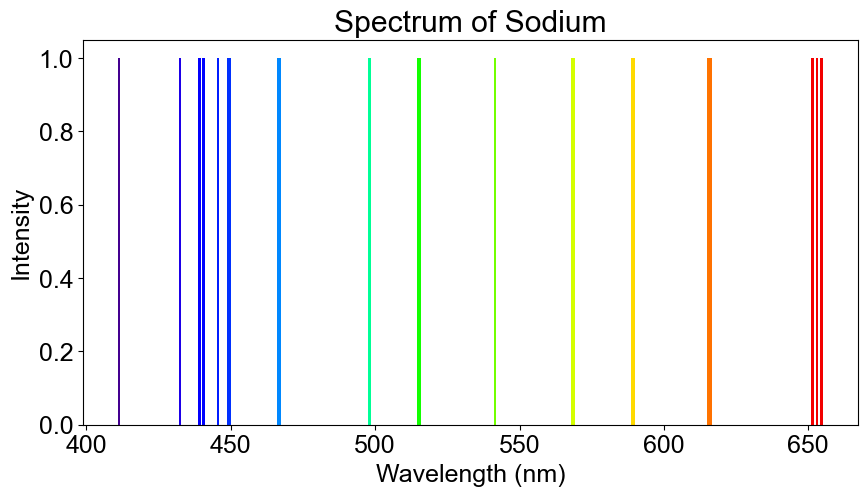

28


In [10]:
#print the spectrum of the element
cd_mercury = scrape_element_data('Sodium')
print(len(cd_mercury))

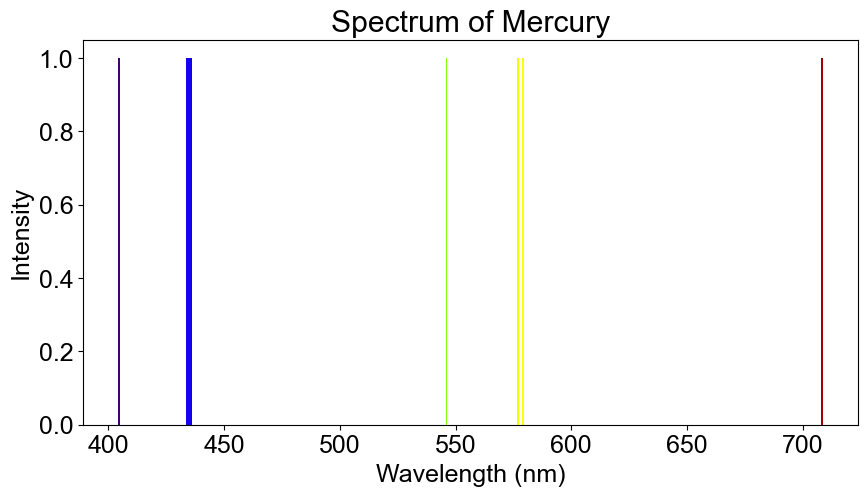

In [8]:
cd_mercury_first_ionization = scrape_element_data('Mercury', only_first_ionization=True)

In [11]:
interactive_spectrum(cd_mercury)

In [29]:
#interactive plot
interactive_spectrum(cd_mercury_first_ionization)

In [66]:
color_rgb_estimations = {
    "rosso1": (255, 0, 0),
    "rosso2": (220, 0, 0),
    "arancione": (255, 165, 0),
    "gialloarancio": (255, 200, 0),
    "verde": (0, 255, 0),
    "azzurro1": (173, 216, 230),
    "azzurro2": (135, 206, 250),
    "blu": (0, 0, 255),
    "viola1": (138, 43, 226),
    "viola2": (148, 0, 211)
}

#fits normalize the values in the range 0-1
color_rgb_estimations = {color: tuple([i/255 for i in rgb]) for color, rgb in color_rgb_estimations.items()}

#assign the wavelength to the colors
assigned_wavelengths = rgb_to_wavelengths(color_rgb_estimations, cd_mercury)
print(assigned_wavelengths)

{'rosso1': 398.3931, 'rosso2': 404.6563, 'arancione': 433.9223, 'gialloarancio': 434.7494, 'verde': 435.8328, 'azzurro1': 512.8442, 'azzurro2': 520.4768, 'blu': 542.5253, 'viola1': 546.0735, 'viola2': 567.7104999999999}


In [8]:
data_Hg = pd.read_csv("data/spettroHg.csv")
#data_Hg['lambda'] = data_Hg['colore'].apply(lambda x: lambdaFromColor(x, 'Hg'))
#data_Hg['lambda'] = data_Hg['lambda'].astype(float)
#convert angle, primes, seconds columns to decimal degrees
data_Hg['angle'] = data_Hg['angle'].astype(float)
data_Hg['primes'] = data_Hg['primes'].astype(float)
data_Hg['seconds'] = data_Hg['seconds'].astype(float)
degree_angle = data_Hg['angle'] + data_Hg['primes']/60 + data_Hg['seconds']/3600
#add the column to the dataframe
data_Hg['degree_angle'] = degree_angle

data_Hg.head(10)

,colore,angle,primes,seconds,wavelength,degree_angle
0,rosso1,150.0,40.0,0.0,734.6508,150.666667
1,rosso2,150.0,56.0,0.0,708.1900,150.933333
2,arancione,151.0,20.0,0.0,579.0663,151.333333
3,gialloarancio,151.0,32.0,30.0,576.9598,151.541667
4,verde,151.0,51.0,0.0,546.0735,151.850000
5,azzurro1,152.0,34.0,0.0,520.4768,152.566667
6,azzurro2,152.0,41.0,0.0,512.8442,152.683333
7,blu,153.0,42.0,0.0,433.9223,153.700000
8,viola1,154.0,30.0,30.0,404.6563,154.508333
9,viola2,154.0,37.0,0.0,398.3931,154.616667


In [37]:
#create a table with colore, degree_angle, wavelength calling them colore linea, angolo [°], lunghezza d'onda [nm]
data_Hg_exp = data_Hg.rename(columns={'colore': 'colore linea', 'degree_angle': 'angolo [°]', 'wavelength': 'lunghezza d\'onda [nm]'})
#drop the columns angle, primes, seconds
data_Hg_exp = data_Hg_exp.drop(columns=['angle', 'primes', 'seconds'])
#print as latex table


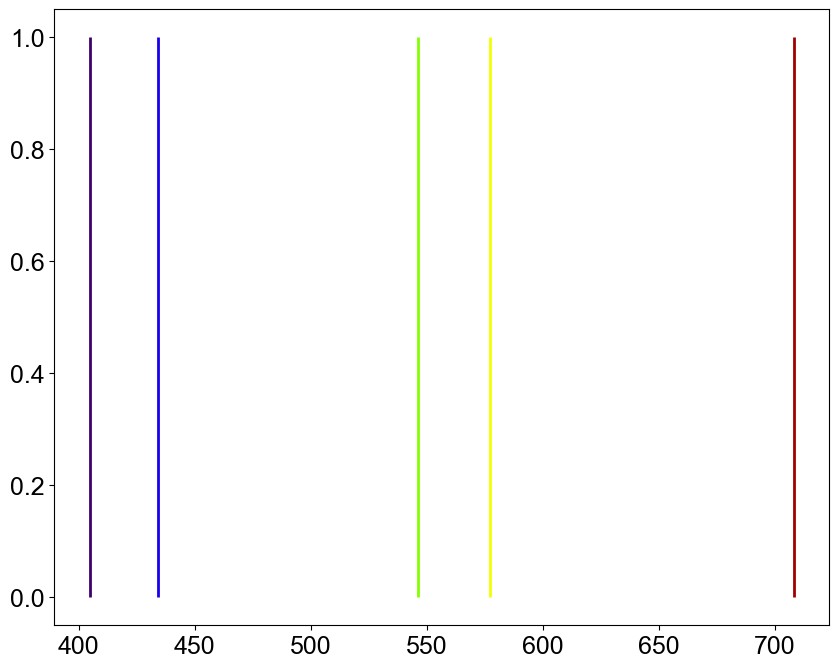

In [9]:
#plot the spectrum of the mercury lamp
#calculate colors from wavelengths
#drop 2-st, 6-th and 7-th row
data_Hg = data_Hg.drop([0,2, 5, 6, 9])
Hg_colors = [wavelength_to_rgb(wave) for wave in data_Hg['wavelength']]
plt.figure(figsize=(10, 8))
#plot the spectrum as vertical lines with the color of the wavelength
plt.vlines(data_Hg['wavelength'], 0, 1, color=Hg_colors, linewidth=2)


### Test cauchy interactive plot

In [33]:
#TEST CAUCHY
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Dati sperimantali
angles_experimental = data_Hg['degree_angle']

# Converti le lunghezze d'onda in micrometri
wavelengths = {k / 1000: v for k, v in cd_mercury.items()}

def cauchy(wavelength, A, B):
    """Calcola l'indice di rifrazione usando l'equazione di Cauchy."""
    return A + B / wavelength**2

def deviation_angle(wavelength, A, B):
    """Calcola l'angolo di deviazione usando l'equazione fornita."""
    n = cauchy(wavelength, A, B)
    alpha = np.deg2rad(60)  # Assumiamo un angolo di prisma di 60 gradi
    delta = 2 * np.arcsin(n * np.sin(alpha / 2)) - alpha
    return np.rad2deg(delta)

def plot(A, B):
    """Crea un grafico delle lunghezze d'onda vs angolo di deviazione."""
    angles = {wavelength*1000: deviation_angle(wavelength, A, B) for wavelength in wavelengths.keys()}
    colors = [color for color in wavelengths.values()]
    values = list(angles.values())
    plt.figure(figsize=(8, 6))
    #plot the spectrum, x axis is angle, y axis just put 1 with color of the wavelength
    #conver colors to list to be able to use it as color
    colors = list(colors)
    plt.scatter(values, [1]*len(values), color=colors)

    #plot the experimental data
    #first shift the values to the left
    angle_exp_shifted = [angle + (values[-1] - angles_experimental[0]) for angle in angles_experimental]
    plt.scatter(angle_exp_shifted, [1]*len(angles_experimental), color='black', marker='x')

    plt.xlabel('Angolo di deviazione (gradi)')
    #add A and B values to the legend
    plt.legend(['A = {:.4f}'.format(A), 'B = {:.6f}'.format(B)])
    plt.show()

    print(values[-1])
# Crea controlli interattivi per A e B
interact(plot,
         A=FloatSlider(min=1.0, max=2.0, step=0.01, value=1.72477),
         B=FloatSlider(min=0.0, max=20e-15, step=0.1e-15, value=7.3971e-15))


interactive(children=(FloatSlider(value=1.72477, description='A', max=2.0, min=1.0, step=0.01), FloatSlider(va…

<function __main__.plot(A, B)>

### Fit Cauchy

In [10]:
def linear_cauchy(one_over_lambda_squared, A, B):
    """Calcola l'indice di rifrazione usando l'equazione di Cauchy."""
    return A + B * one_over_lambda_squared

A =  1.723906831650556
B =  7.455644922971425e-15
Covariance matrix: 
[[ 2.08497079e-06 -4.59271696e-19]
 [-4.59271696e-19  1.16157027e-31]]


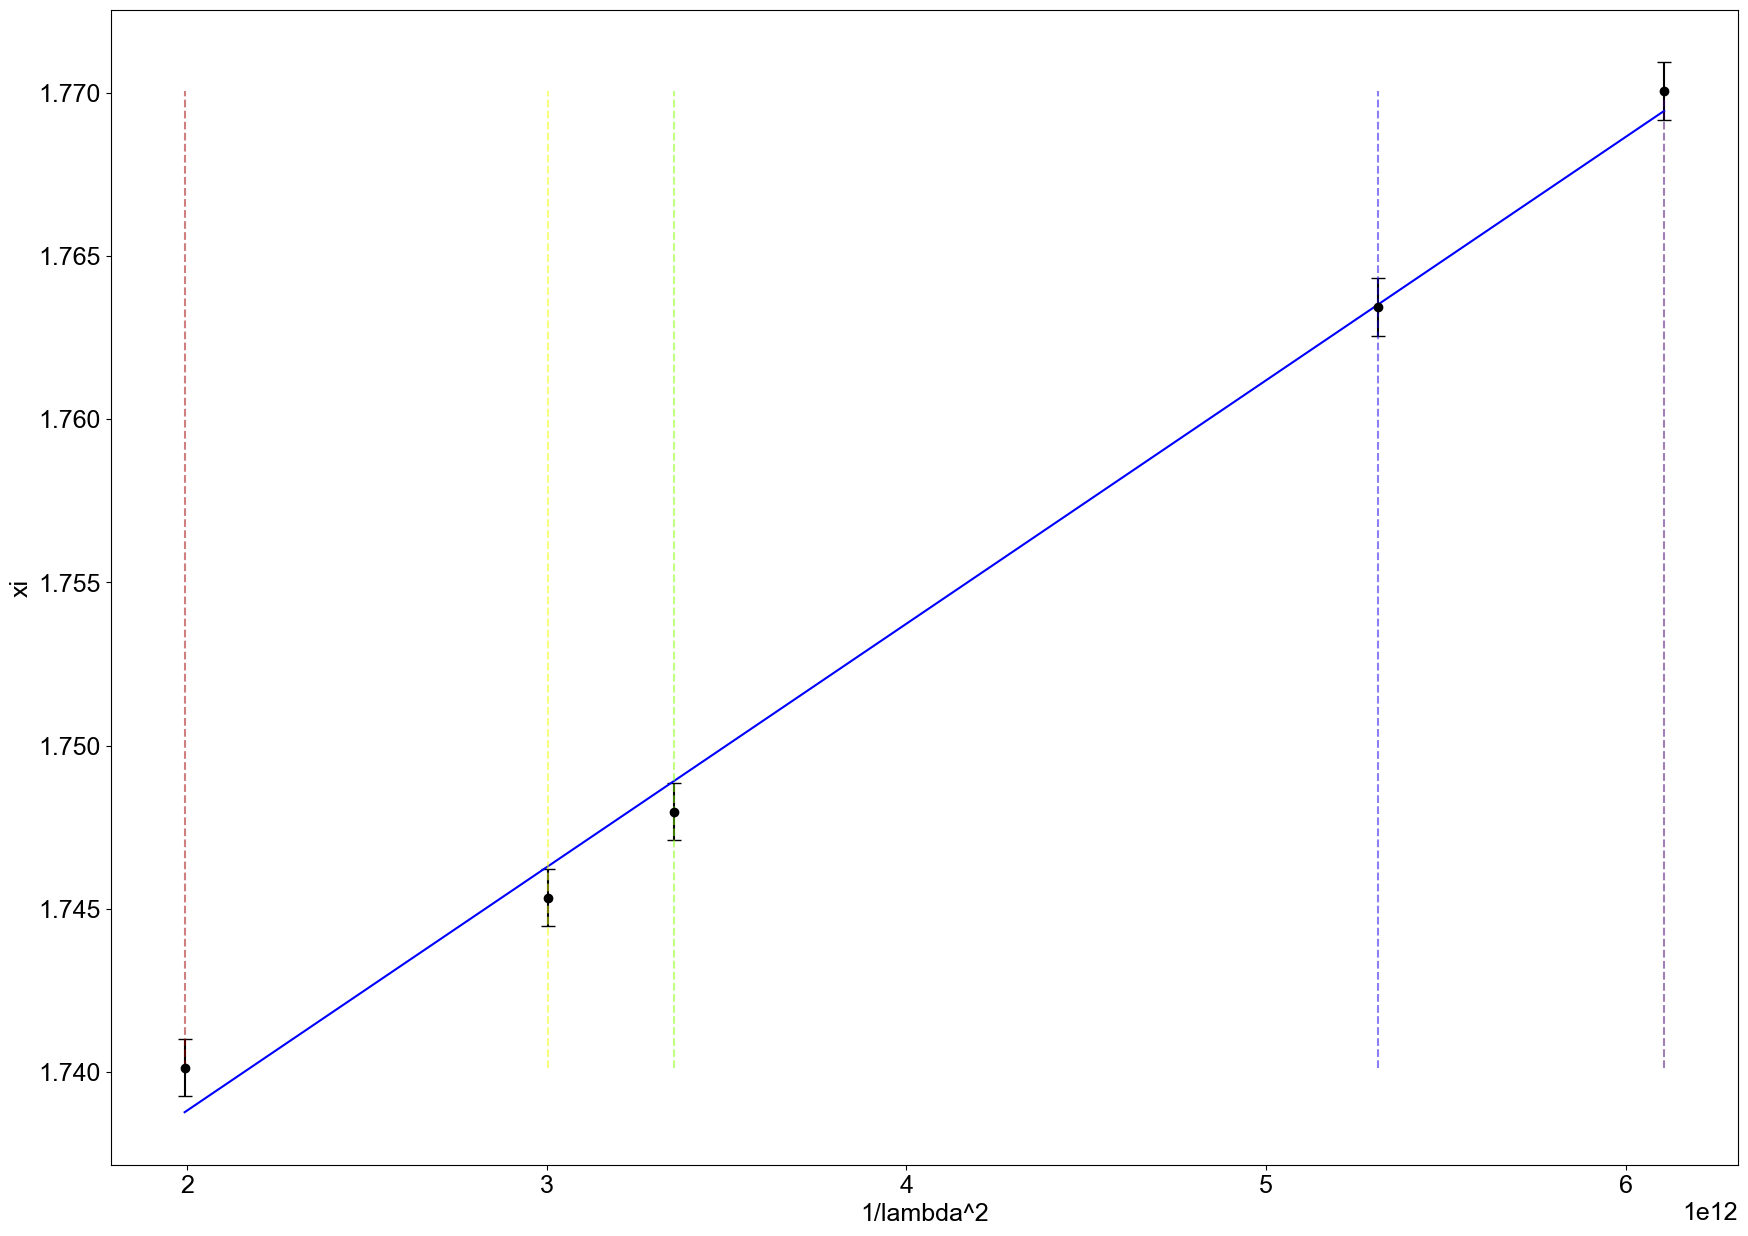

In [49]:
#plot delta vs wavelength

#ignore rows without wavelength
data_Hg_w = data_Hg[data_Hg['wavelength'].notna()]
#remove the two 6-th and 7-th and 1-st rows
#data_Hg_w = data_Hg_w.drop([6, 7, 1])

#calculate delta as angle in data_Hg - 90 also convert to radians
deltas = [math.radians(angle - 90) for angle in data_Hg_w['degree_angle']]
#calculate xi
xis = [calculate_xi(delta, math.radians(60)) for delta in deltas]
xis_err = [calculate_xi_error(delta, math.radians(60), error_angle_strumento, error_angle_prisma) for delta in deltas]
#xis_sigmas = [xie / math.sqrt(12) for xie in xis_err] #from uniform distribution calculate sigma
#use error as 0.0005*100 = 0.05% of the value
xis_sigmas = [0.0005 * xi for xi in xis] 
#1/lambda^2 (convert to micrometers)
one_over_lambda_squared = [1/(wavelength*1e-9)**2 for wavelength in data_Hg_w['wavelength']]
#fit with linear_cauchy
reg = curve_fit(linear_cauchy, one_over_lambda_squared, xis)

print('A = ', reg[0][0])
print('B = ', reg[0][1])
#print covariance matrix
print('Covariance matrix: ')
print(reg[1])
#plot (color of each point should be calculated from the wavelength)
colrs_plot = [wavelength_to_rgb(wavelength) for wavelength in data_Hg_w['wavelength']]
plt.errorbar(one_over_lambda_squared, xis, yerr=xis_sigmas, fmt='o', color='black')
#plot the fit
cauchy_fit_x = np.linspace(min(one_over_lambda_squared), max(one_over_lambda_squared), 100)
cauchy_hyp = [linear_cauchy(x, reg[0][0], reg[0][1]) for x in cauchy_fit_x]
plt.plot(cauchy_fit_x, cauchy_hyp, color='blue')

#plot vertical lines of the spectrum
plt.vlines(one_over_lambda_squared, min(xis), max(xis), color=colrs_plot, linewidth=1.5, linestyles='dashed', alpha=0.5)

plt.xlabel('1/lambda^2')
plt.ylabel('xi')
plt.show()

In [41]:
print('A = ', reg[0][0])
print('A err', math.sqrt(reg[1][0][0]))
print('B = ', reg[0][1])
print('B err', math.sqrt(reg[1][1][1]))


A =  1.723906831650556
A err 0.001443942792018483
B =  7.455644922971425e-15
B err 3.408181730458767e-16


In [50]:
#save 1/lambda^2 and xis in csv file for fitting with ROOT
fit_cauchy_data = pd.DataFrame({'gamma': one_over_lambda_squared, 'xis': xis, 'xis_err': xis_sigmas})
fit_cauchy_data.to_csv('data/fit_cauchy_data.csv', index=False)

In [34]:
def non_linear_cauchy(wavelength, A, B):
    """delta as a function of wavelength."""
    return 2 * np.arcsin((A + (B/(wavelength**2))) * np.sin(np.deg2rad(60) / 2)) - np.deg2rad(60)

A =  1.7238456355936542
A_err =  0.0014375000334482196
B =  7.471329472791413e-15
B_err =  3.3422692352936593e-16
Covariance matrix:
[[ 2.06640635e-06 -4.49087234e-19]
 [-4.49087234e-19  1.11707636e-31]]


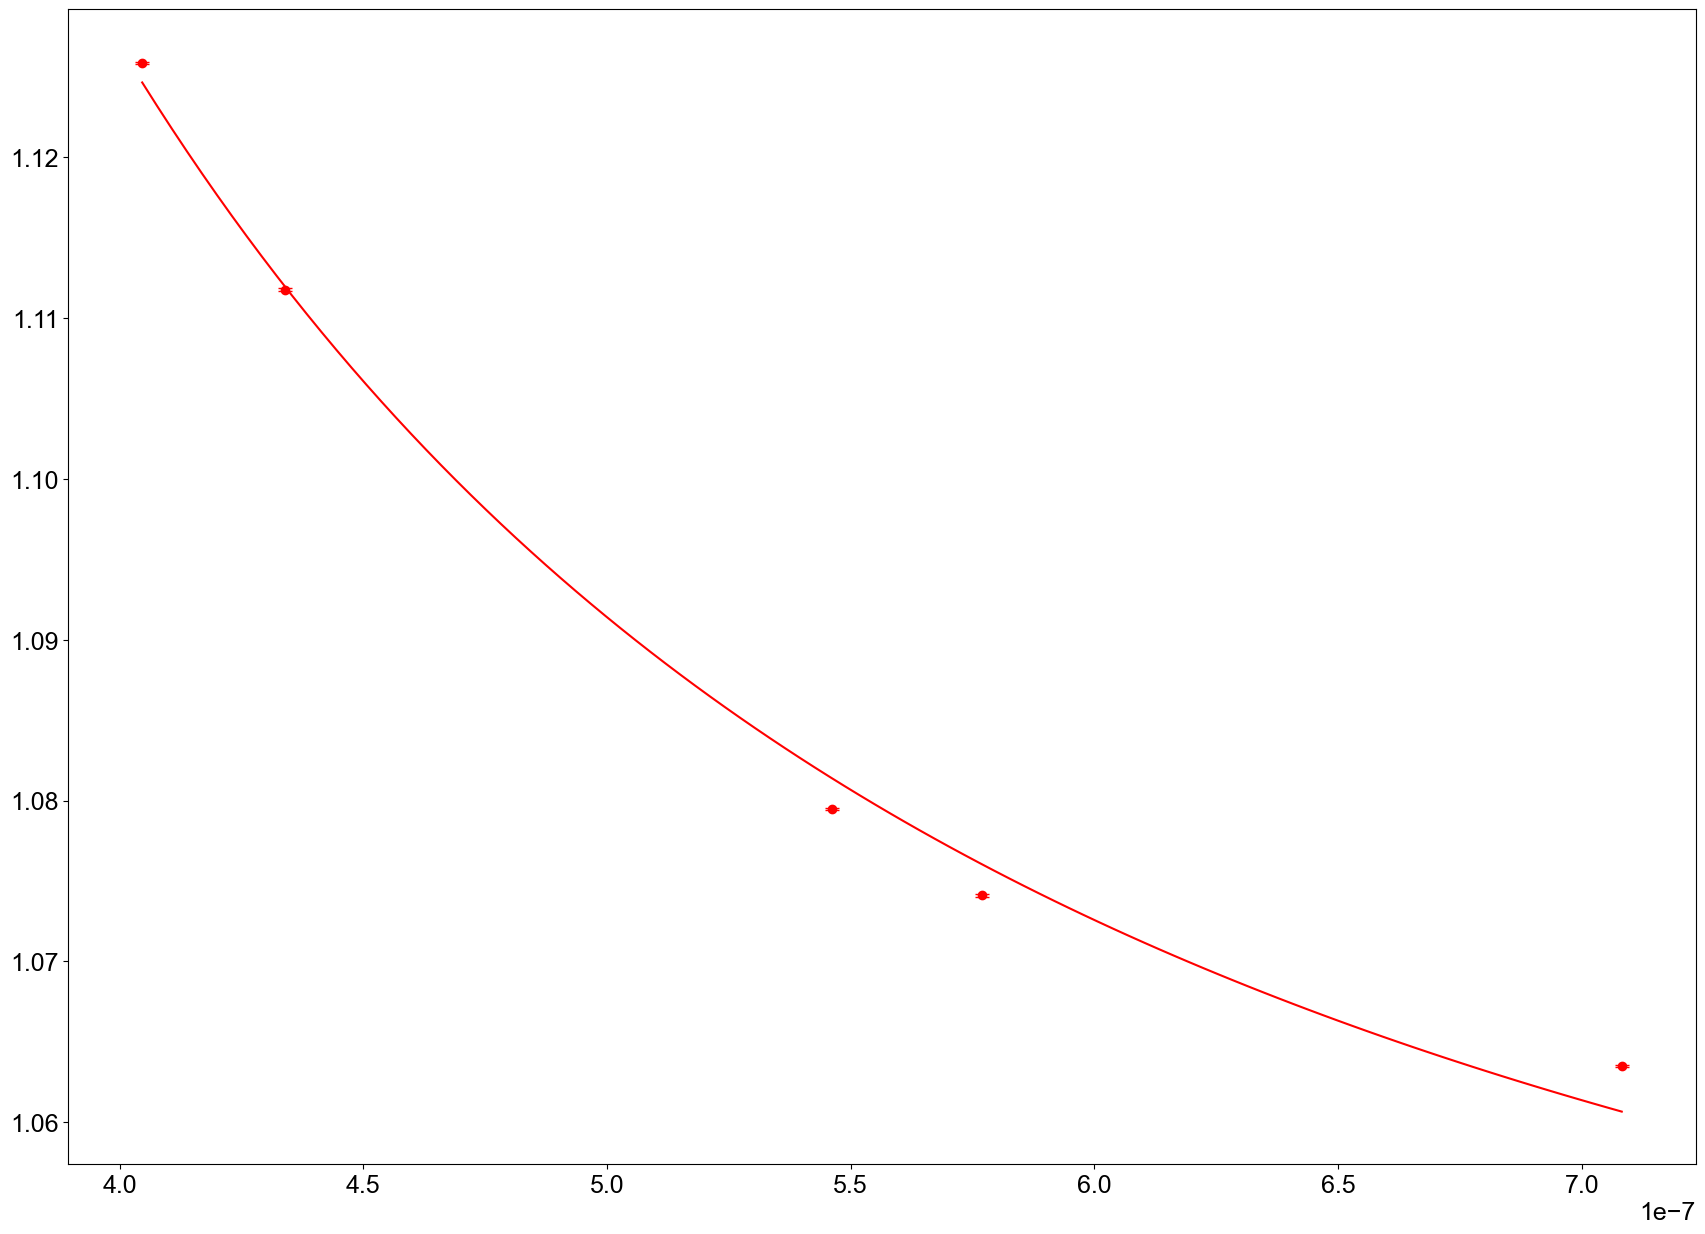

In [35]:
#plot non linearized data (wavelength vs delta)
wavelegths_meter = [wavelength*1e-9 for wavelength in data_Hg_w['wavelength']]
plt.errorbar(wavelegths_meter, deltas, yerr=error_angle_strumento, fmt='o', color="red")
#fit with non_linear_cauchy
init_guess = [1.72477, 7.3971e-15]
reg = curve_fit(non_linear_cauchy, wavelegths_meter, deltas, p0=init_guess)
#print A and B
print('A = ', reg[0][0])
print('A_err = ', np.sqrt(reg[1][0][0]))
print('B = ', reg[0][1])
print('B_err = ', np.sqrt(reg[1][1][1]))
#print covariance matrix
print('Covariance matrix:')
print(reg[1])
#plot the fit

#plot non linear function
non_linear_cauchy_x = np.linspace(min(wavelegths_meter), max(wavelegths_meter), 100)
non_linear_cauchy_hyp = [non_linear_cauchy(wavelength, reg[0][0], reg[0][1]) for wavelength in non_linear_cauchy_x]
plt.plot(non_linear_cauchy_x, non_linear_cauchy_hyp, color='red')

## Gas ignoto prisma

Si trova l'angolo minimo per una delle linee, poi si sposta solo l'oculare per misurare le altre

**NOTA**: L'angolo $A$ è l'angolo del prisma $\rightarrow A = 60°$

Una volta misurati gli angoli possiamo $n$, indice di rifrazione per ciascuna lunghezza d'onda

In [20]:
def calculate_lambda(n_unk, A, B):
    """Calcola la lunghezza d'onda usando l'equazione di Cauchy."""
    return math.sqrt(B/(n_unk - A))
    

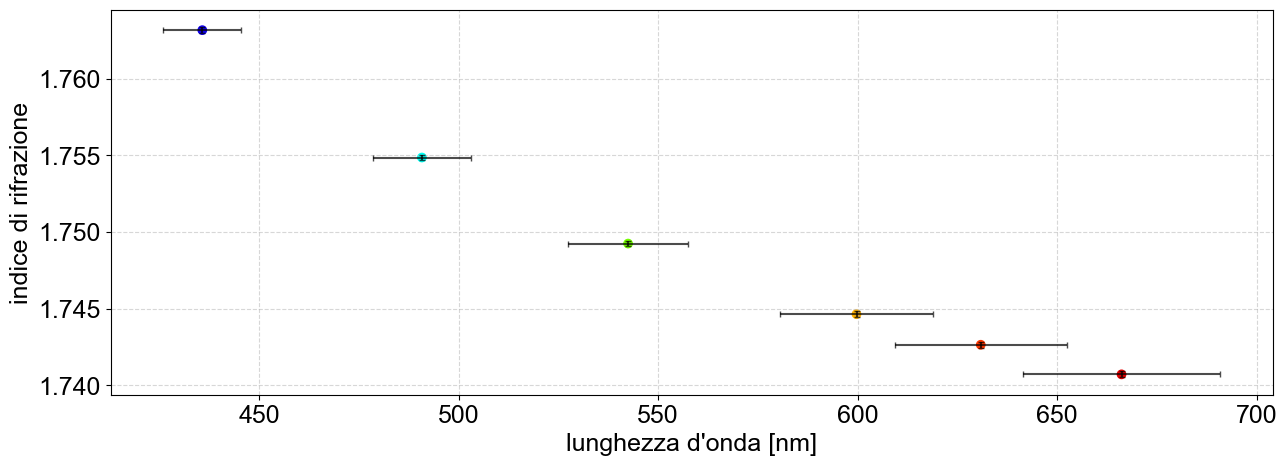

In [21]:
A = 1.72392
B = 7.45111e-15
A_err = 0.00108828
B_err = 2.58044e-16
AB_cov = -2.61995e-19

data_unknown = pd.read_csv('data/prisma_gas_ignoto.csv')
#calculate angle in radians from angle, primes and seconds
angle_unk = (data_unknown['angolo'] + data_unknown['primi'] / 60 + data_unknown['secondi'] / 3600).to_list()
angle_unk = [math.radians(angle-90) for angle in angle_unk]
angle_unk_err = [error_angle_strumento for i in range(len(angle_unk))]

#calculate refraction index from angle
n_unk = [calculate_xi(angle, math.radians(60)) for angle in angle_unk]
n_unk_err = [calculate_xi_error(angle, math.radians(60), error_angle_strumento, error_angle_prisma) for angle in angle_unk]
n_unk_err_old = [calculate_xi_error_old(angle, math.radians(60), error_angle_strumento, error_angle_prisma) for angle in angle_unk]

#calculate labda using coefficients from the fit
lambda_unk = []
lambda_unknown_err = []
for i in range(len(n_unk)):
    l = math.sqrt(B/(n_unk[i] - A))
    lambda_unk.append(l)

    # calculate the partial derivatives
    B_partial = 1/2 * np.sqrt((1/B*(n_unk[i] - A)))
    A_partial = 1/2 * np.sqrt((B/(n_unk[i] - A)**3))
    B_term = 1/4 * (1/(B*(n_unk[i] - A))) * B_err**2
    A_term = 1/4 * (B/(n_unk[i] - A)**3) * A_err**2
    n_term = 1/4 * (B/(n_unk[i] - A)**3) * n_unk_err[i]**2
    #cov_term = 1/2 * (1/(n_unk[i] - A)**2) * AB_cov
    cov_term = 2*B_partial*A_partial*AB_cov
    # calculate the error
    sigma_l = np.sqrt(B_term + A_term + n_term) + cov_term
    lambda_unknown_err.append(sigma_l)

#plot refraction index vs wavelength
lambda_unk_nm = [l*1e9 for l in lambda_unk]
lambda_unknown_err_nm = [l*1e9 for l in lambda_unknown_err]
plt.figure(figsize=(15, 5))
colors_ = [wavelength_to_rgb(wavelength) for wavelength in lambda_unk_nm]
#scatter plot with color based on wavelength and "x" as marker
plt.scatter(lambda_unk_nm, n_unk, c=colors_, marker='o')
#make errorbars black and with 0.5 alpha
plt.errorbar(lambda_unk_nm, n_unk, xerr=lambda_unknown_err_nm, yerr=n_unk_err, fmt='', linestyle='', ecolor='black', capsize=2, alpha=0.7)
#add dashed grid lines
plt.grid(linestyle='--', alpha=0.5)
#plot teoretical function n(lambda)=A+B/lambda^2

plt.xlabel('lunghezza d\'onda [nm]')
plt.ylabel('indice di rifrazione')
plt.show()

In [23]:
#print mean error on lambda
print('mean error on lambda = ', np.mean(lambda_unknown_err_nm))
#calculate error percentages
lambda_unknown_err_perc = [100*lambda_unknown_err_nm[i]/lambda_unk_nm[i] for i in range(len(lambda_unknown_err_nm))]
print('mean error percentage on lambda = ', np.mean(lambda_unknown_err_perc))

mean error on lambda =  17.072120776000506
mean error percentage on lambda =  2.9697437886741866


In [34]:
#print in latex format data of unknown gas: colore, angolo (a string with angle prime and seconds)
angles = [str(data_unknown['angolo'][i]) + '°' + str(data_unknown['primi'][i]) + '\'' + str(data_unknown['secondi'][i]) + '"' for i in range(len(data_unknown['angolo']))]
to_print_df = pd.DataFrame({'colore': data_unknown['colore'], 'angolo': angles})
print(to_print_df.to_latex(index=False))

\begin{tabular}{ll}
\toprule
   colore &     angolo \\
\midrule
    rosso &   151°0'0" \\
arancione & 151°13'30" \\
   giallo & 151°27'30" \\
    verde &   152°0'0" \\
  azzurro &  152°40'0" \\
    viola &  153°40'0" \\
\bottomrule
\end{tabular}



C:\Users\giova\AppData\Local\Temp\ipykernel_49364\4113350540.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(to_print_df.to_latex(index=False))


<ErrorbarContainer object of 3 artists>

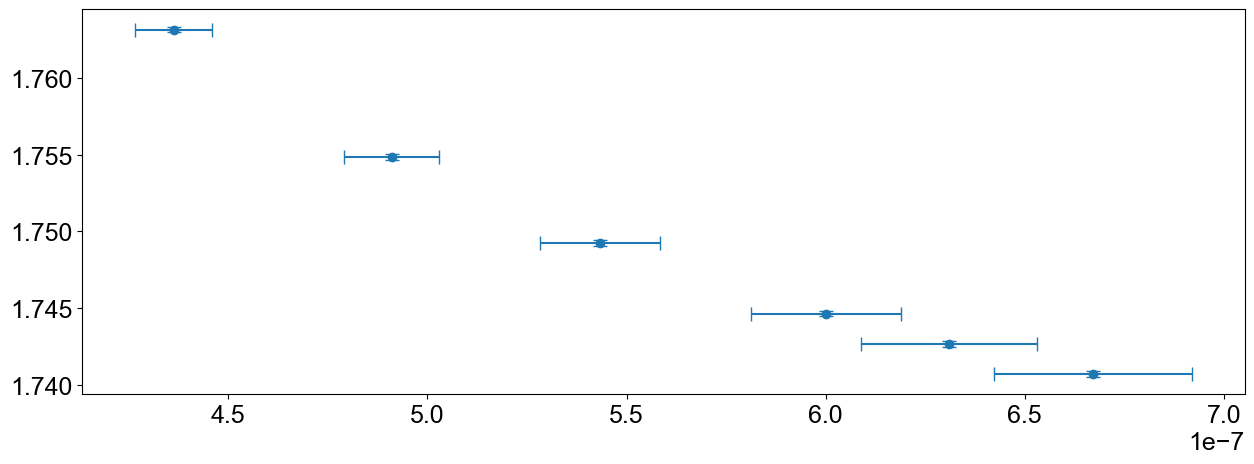

In [9]:
#let's try with montecarlo error propagation
lambdas = []
lambdas_err = []

for i in range(len(n_unk)):
    func_params = [n_unk[i], A, B]
    func_params_err = [n_unk_err[i]*0.1, A_err, B_err]
    try:
        l, l_err = lu.monte_carlo_error_propagation(calculate_lambda, func_params, func_params_err, 1000)
    except ValueError:
        pass
    lambdas.append(l)
    lambdas_err.append(l_err)

plt.figure(figsize=(15, 5))
plt.errorbar(lambdas, n_unk, xerr=lambdas_err, yerr=n_unk_err, fmt='o')


#### Find gas element

In [9]:
def closest_element(experimental_wavelengths, wavelengths_error, element_names, intensity_threshold=0.1):
    # Initialize minimum difference and closest element variables
    min_difference = float('inf')
    closest_element = None
    elemnts_distances = []

    # Loop through each provided element
    for element in element_names:
        # Scrape data for the current element
        try:
            element_data = scrape_element_data(element, only_first_ionization=True, graph=False, intensity_threshold=intensity_threshold)
        except:
            print('error while scraping element', element)
            continue

        # Get the wavelengths as a list
        element_wavelengths = list(element_data.keys())
        # if the element has less than experimental_wavelengths, skip it
        if len(element_wavelengths) < len(experimental_wavelengths):
            continue

        # Calculate the sum of absolute differences between each experimental wavelength 
        # and the closest wavelength in the element data
        difference = 0
        for i,ew in enumerate(experimental_wavelengths):
            difference += min(abs(ew - ew_prime) for ew_prime in element_wavelengths)/wavelengths_error[i]**2

        # Save the distance for each element
        elemnts_distances.append({element: difference})

        # If the current element has a smaller difference than the current minimum, update minimum and closest element
        if difference < min_difference:
            min_difference = difference
            closest_element = element

    # If no element had a smaller difference than infinity, raise an exception
    if closest_element is None:
        raise ValueError("None of the provided elements match any of the experimental wavelengths.")
    
    # Return the element that has the smallest difference with the experimental data
    return closest_element, elemnts_distances


In [10]:
elements_ = [
    "Actinium", "Aluminum", "Americium", "Antimony", "Argon", "Arsenic", "Astatine",
    "Barium", "Berkelium", "Beryllium", "Bismuth", "Boron", "Bromine", "Cadmium",
    "Calcium", "Californium", "Carbon", "Cerium", "Cesium", "Chlorine", "Chromium",
    "Cobalt", "Copper", "Curium", "Dysprosium", "Einsteinium", "Erbium", "Europium",
    "Fluorine", "Francium", "Gadolinium", "Gallium", "Germanium", "Gold", "Hafnium",
    "Helium", "Holmium", "Hydrogen", "Indium", "Iodine", "Iridium", "Iron", "Krypton",
    "Lanthanum", "Lead", "Lithium", "Lutetium", "Magnesium", "Manganese", "Mercury",
    "Molybdenum", "Neodymium", "Neon", "Neptunium", "Nickel", "Niobium", "Nitrogen",
    "Osmium", "Oxygen", "Palladium", "Phosphorus", "Platinum", "Plutonium", "Polonium",
    "Potassium", "Praseodymium", "Promethium", "Protactinium", "Radium", "Radon",
    "Rhenium", "Rhodium", "Rubidium", "Ruthenium", "Samarium", "Scandium", "Selenium",
    "Silicon", "Silver", "Sodium", "Strontium", "Sulfur", "Tantalum", "Technetium",
    "Tellurium", "Terbium", "Thallium", "Thorium", "Thulium", "Tin", "Titanium",
    "Tungsten", "Uranium", "Vanadium", "Xenon", "Ytterbium", "Yttrium", "Zinc",
    "Zirconium"
]
elements = ["Mercury", "Sodium", "Scandium", "Thallium", "Hydrogen", "Helium", "Neon", "Argon", "Xenon", "Oxygen"]

lambda_unk_nm = [l*1e9 for l in lambda_unk]
lambda_unknown_err_nm = [l*1e9 for l in lambda_unknown_err]
#unk_element = closest_element(lambda_unk_nm, elements, intensity_threshold=100)
#try to check closest element with different intensity threshold
unk_elements = []
intensities = []
elements_distances = []

for i in range(0, 300, 50):
    try:
        print('intensity threshold', i)
        unk_element, el_dist = closest_element(lambda_unk_nm, lambda_unknown_err_nm, elements, intensity_threshold=i)
        unk_elements.append(unk_element)
        intensities.append(i)
        elements_distances.append(el_dist)
        continue
    except:
        print('no element found with intensity threshold', i)
        continue

intensity threshold 0
intensity threshold 50
intensity threshold 100
intensity threshold 150
intensity threshold 200
intensity threshold 250


In [11]:
print(unk_elements)
print(intensities)

['Neon', 'Neon', 'Neon', 'Neon', 'Helium', 'Scandium']
[0, 50, 100, 150, 200, 250]


In [12]:
print(elements_distances)
#save elements_distances to file
with open('data/elements_distances_chosen.txt', 'w') as f:
    f.write(str(elements_distances))

[[{'Mercury': 0.6219549497661321}, {'Sodium': 0.3356777996791926}, {'Scandium': 0.33979158768619017}, {'Hydrogen': 0.5228460442412571}, {'Helium': 0.32183329564415164}, {'Neon': 0.22137944640991167}, {'Argon': 0.26062577573176}, {'Xenon': 0.43816036735729025}, {'Oxygen': 1.5073707219769716}], [{'Mercury': 0.695436009956624}, {'Scandium': 0.7914242640591296}, {'Helium': 0.4871128046056068}, {'Neon': 0.23071696207790116}, {'Argon': 5.269440628223226}, {'Xenon': 0.7696834639728379}, {'Oxygen': 1.5073707219769716}], [{'Scandium': 2.8594987583461213}, {'Helium': 0.4871128046056068}, {'Neon': 0.24120154120704804}, {'Argon': 5.269440628223226}, {'Oxygen': 3.1675948882312372}], [{'Scandium': 2.8594987583461213}, {'Helium': 0.7262675362549297}, {'Neon': 0.5916309413545986}, {'Argon': 5.269440628223226}, {'Oxygen': 3.192290491650123}], [{'Scandium': 2.8594987583461213}, {'Helium': 0.7262675362549297}, {'Neon': 1.5457210312386558}, {'Argon': 5.269440628223226}], [{'Scandium': 2.8594987583461213},

[453.77545, 470.43949000000003, 470.88594, 471.00649999999996, 471.20633, 471.5344, 475.2732, 478.89258, 479.02195, 482.7338, 488.49170000000004, 500.51587, 503.77511999999996, 514.49384, 533.07775, 534.10938, 534.32834, 540.05618, 556.27662, 565.66588, 571.92248, 574.82985, 576.4418800000001, 580.44496, 582.01558, 585.24879, 587.2827500000001, 588.18952, 590.24623, 590.64294, 594.48342, 596.5471, 597.46273, 597.5534, 598.79074, 602.99969, 607.43377, 609.61631, 612.8449899999999, 614.3062600000001, 616.35939, 618.2146, 621.72812, 626.6495, 630.47889, 632.81646, 633.4427800000001, 638.29917, 640.2248, 650.65281, 653.28822, 659.89529, 665.2092700000001, 667.82762, 671.7043, 692.94673, 702.40504, 703.24131, 705.12923, 705.91074, 717.39381, 724.51666, 747.24386, 748.88712, 753.57741, 754.4044299999999, 772.4623300000001]


Text(0, 0.5, 'Indice di rifrazione')

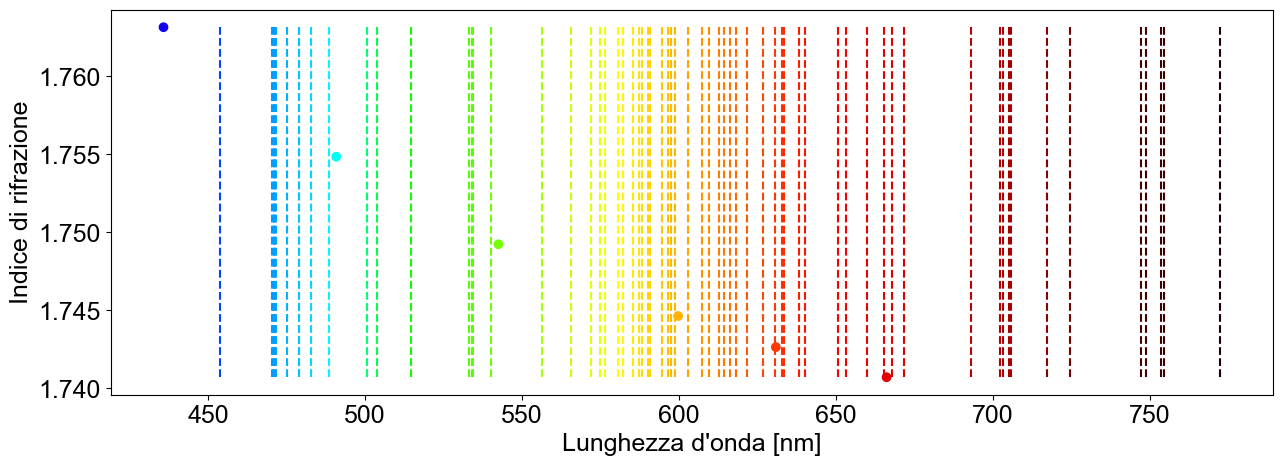

In [10]:
#plot spectrum of the unknown gas from experimental data

#color from wavelength
colrs_unk = [wavelength_to_rgb(wavelength) for wavelength in lambda_unk_nm]

plt.figure(figsize=(15, 5))
plt.scatter(lambda_unk_nm, n_unk, color=colrs_unk)

#cd_argon = scrape_element_data('Argon', graph=False, intensity_threshold=1000, only_first_ionization=True)

#plot vertical lines at the wavelengths of the closest element spectrum
predicted_elemet_cd = scrape_element_data('Neon', graph=False, intensity_threshold=0, only_first_ionization=True)
predicted_elemet_cd_wavelengths = list(predicted_elemet_cd.keys())
predicted_elemet_cd_wavelengths = [wavelength for wavelength in predicted_elemet_cd_wavelengths]
#predicted_elemet_cd_wavelengths = [wavelength for wavelength in predicted_elemet_cd_wavelengths if wavelength <= 780]
#predicted_elemet_cd_wavelengths = [wavelength for wavelength in predicted_elemet_cd_wavelengths if wavelength >= 380]
print(predicted_elemet_cd_wavelengths)

#color from wavelength
colrs_cd = [wavelength_to_rgb(wavelength) for wavelength in predicted_elemet_cd_wavelengths]

plt.vlines(predicted_elemet_cd_wavelengths, min(n_unk), max(n_unk), color=colrs_cd, linestyles='dashed')
plt.xlabel('Lunghezza d\'onda [nm]')
plt.ylabel('Indice di rifrazione')


Text(0.5, 0, "Lunghezza d'onda [nm]")

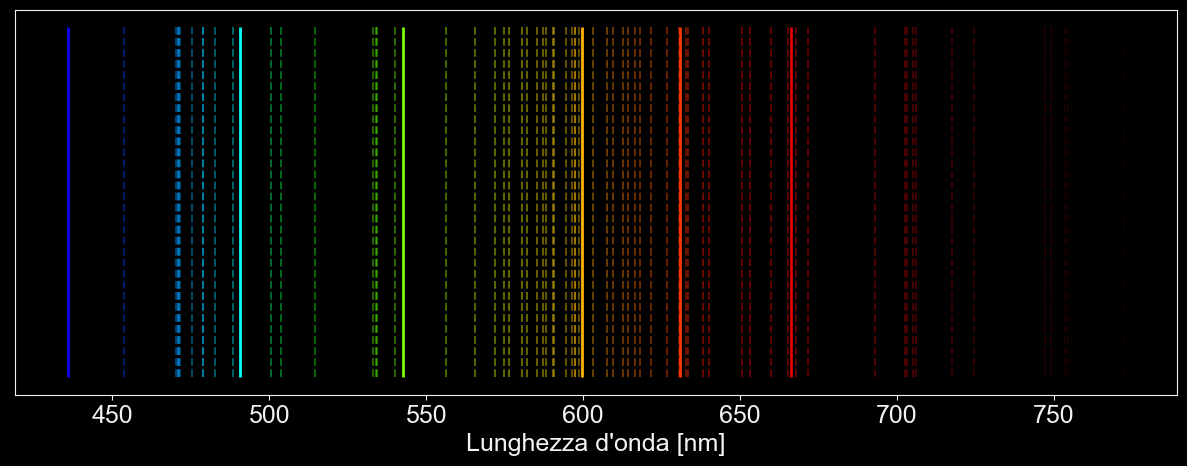

In [20]:

# Set the colors
plt.rcParams['axes.facecolor'] = 'black'     # Background color
plt.rcParams['axes.edgecolor'] = '#f2f2f2'     # Axis lines color
plt.rcParams['xtick.color'] = '#f2f2f2'        # X-axis tick color
plt.rcParams['ytick.color'] = '#f2f2f2'        # Y-axis tick color
plt.rcParams['text.color'] = '#f2f2f2'         # Text (labels, titles) color
plt.rcParams['figure.facecolor'] = 'black'   # Figure background color
plt.rcParams['figure.edgecolor'] = 'black'   # Figure border color
plt.rcParams['savefig.facecolor'] = 'black'  # Figure background color when saving
plt.rcParams['savefig.edgecolor'] = 'black'  # Figure border color when saving
plt.rcParams['axes.labelcolor'] = '#f2f2f2'    # Label color

#make a graph to compera the experimental spectrum with the predicted one (use vertical lines)
plt.figure(figsize=(15, 5))
plt.vlines(lambda_unk_nm, 0, 1, color=colrs_unk, linewidth=2)
plt.vlines(predicted_elemet_cd_wavelengths, 0, 1, color=colrs_cd, linestyles='dashed', alpha=0.4)

#change background color to black
ax = plt.gca()
ax.set_facecolor('black')

#remove y axis ticks
plt.yticks([])

plt.xlabel('Lunghezza d\'onda [nm]')



Text(0, 0.5, 'Refraction Index')

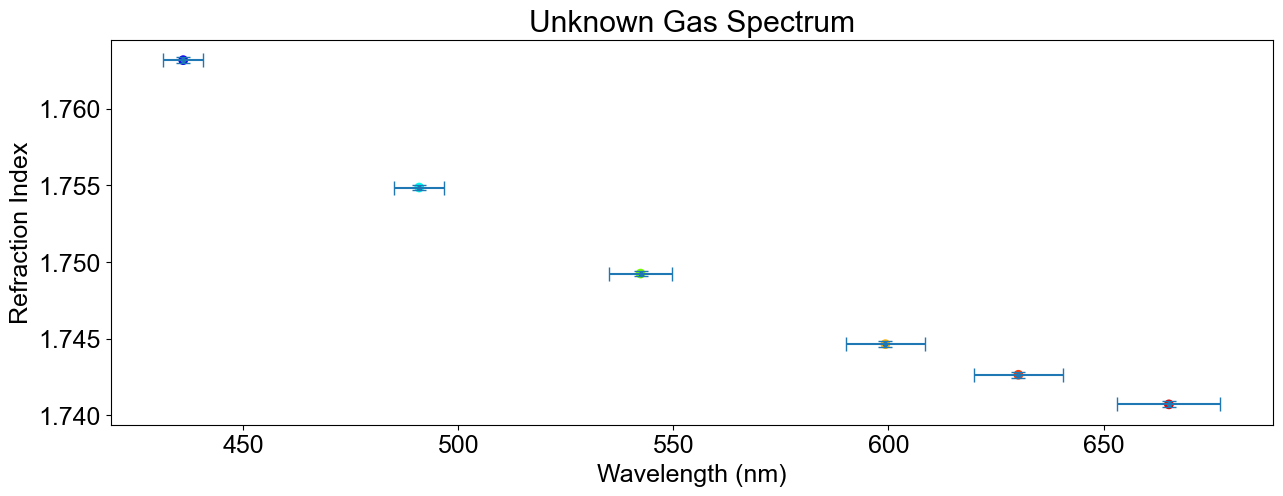

In [99]:
#plot just unknown gas spectrum
colrs_unk = [wavelength_to_rgb(wavelength) for wavelength in lambda_unk_nm]
plt.figure(figsize=(15, 5))
plt.scatter(lambda_unk_nm, n_unk, color=colrs_unk)
plt.errorbar(lambda_unk_nm, n_unk, xerr=lambda_unknown_err_nm, yerr=n_unk_err, fmt='.')
plt.title('Unknown Gas Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Refraction Index')

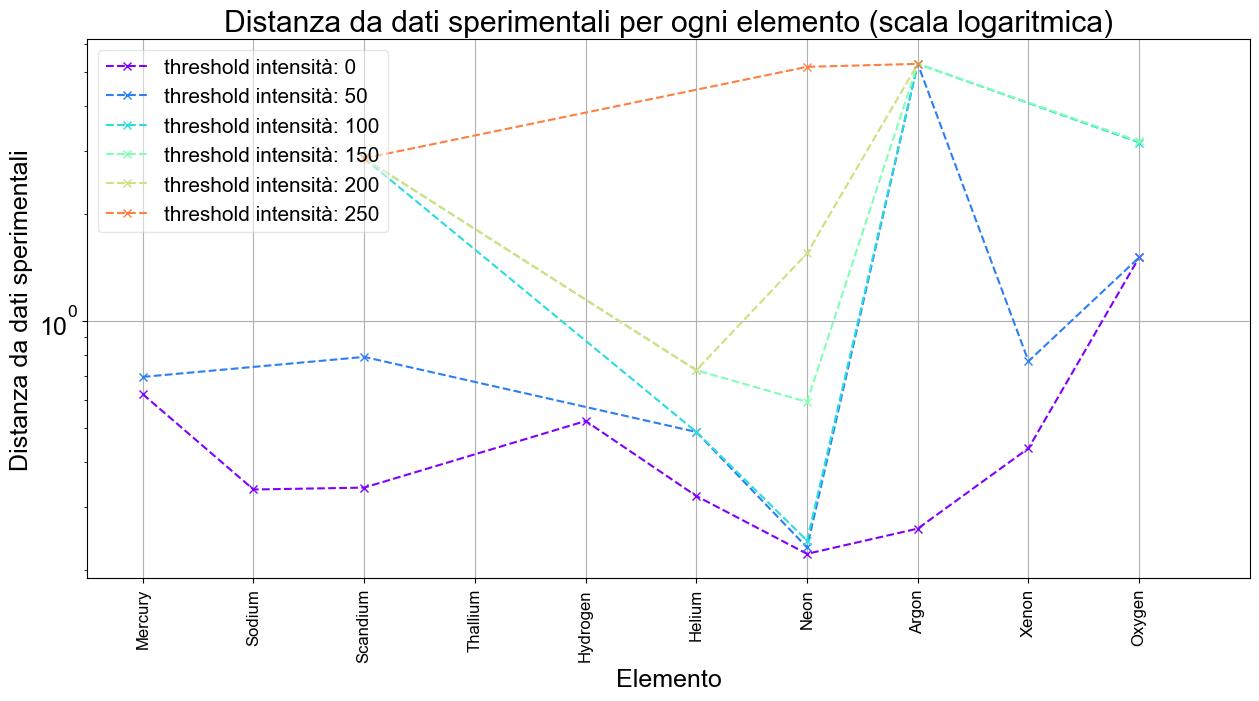

In [23]:
""" Plot elements tried with their distance from the experimental data for each intensity threshold
I want a single plot with all the elements and their distance from the experimental data for each intensity threshold
it should be a scatter plot with the x axis being the element and the y axis being the distance from the experimental data
for each threshold there should be a different color
elements_distances is a list of dictionaries, each dictionary has the element as key and the distance from the experimental data as value
Not all elements are present for evry intensity threshold, so I need to remove the elements that are not present for each threshold
"""
all_elements = elements.copy()

x_ticks = [i for i in range(len(elements))]
fig, ax = plt.subplots(figsize=(15, 7))

for i, intensity in enumerate(intensities):
    # Collect the keys for the current intensity level
    keys_i = [list(el_dist.keys()) for el_dist in elements_distances[i]]
    keys_i = [item for sublist in keys_i for item in sublist]

    # Create a new list with only the needed elements
    elements_i = [element for element in all_elements if element in keys_i]

    #get the distance from the experimental data for each element
    distances = []
    for dict in elements_distances[i]:
        distances.append(dict.values())
    distances = [item for sublist in distances for item in sublist]

    #plot the elements with the distance from the experimental data
    elements_int_order = [all_elements.index(el) for el in elements_i]

    #get a color from index i
    color = plt.cm.rainbow(i/len(intensities))
    ax.plot(elements_int_order, distances, color=color, label='threshold intensità: ' + str(intensity), marker='x', linestyle='dashed')


#set x limits and ticks
ax.set_xlim(-0.5, len(all_elements))
x_ticks = [i for i in range(len(all_elements))]
ax.set_xticks(x_ticks)
ax.set_xticklabels(all_elements)
#make legent smaller and semi transparent
leg = ax.legend(loc='upper left', fancybox=True, shadow=False, fontsize='small', framealpha=0.5)
ax.set_title('Distanza da dati sperimentali per ogni elemento (scala logaritmica)')
#rotate x labels 90 degrees and make them smaller
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=12)
ax.set_xlabel('Elemento')
ax.set_ylabel('Distanza da dati sperimentali')
#make the graph in log scale
ax.set_yscale('log')
#put more values on y axis (i want to se like values in between 1 and 10)
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=range(1,10)))
#add grid
ax.grid(True)
plt.show()


In [33]:
# Organize data by element
organized_data = {}
for inner_list in elements_distances:
    for element in inner_list:
        for key, value in element.items():
            if key not in organized_data:
                organized_data[key] = [value]
            else:
                organized_data[key].append(value)


print(mean_values)

# Calculate inverse of mean distances
inverse_distances = {key: 1 / value for key, value in mean_values.items()}

# Calculate sum of all inverse distances
total_inverse_distance = sum(inverse_distances.values())

# Calculate confidence for each element
confidence_values = {key: (value / total_inverse_distance) * 100 for key, value in inverse_distances.items()}

# Print the confidence that Neon is the closest element
print(f"The confidence that Neon is the closest element is {confidence_values['Neon']}%")

# Print all confidence values
print("All confidence values: ", confidence_values)


{'Mercury': 0.658695479861378, 'Sodium': 0.3356777996791926, 'Scandium': 1.3302382033638136, 'Hydrogen': 0.5228460442412571, 'Helium': 0.4320196349517884, 'Neon': 0.23109931656495364, 'Argon': 3.5998356773927376, 'Xenon': 0.6039219156650641, 'Oxygen': 2.06077877739506}
The confidence that Neon is the closest element is 26.674056798646955%
All confidence values:  {'Mercury': 9.35843114860808, 'Sodium': 18.36390819432606, 'Scandium': 4.634024402993443, 'Hydrogen': 11.790002743785978, 'Helium': 14.268694747797708, 'Neon': 26.674056798646955, 'Argon': 1.7123993561413728, 'Xenon': 10.207207482102415, 'Oxygen': 2.9912751255979835}


## Reticolo
### Determinazione del passo del reticolo

In [7]:
data_reticolo = pd.read_csv('data/sodio_reticolo.csv')
data_reticolo.head(10)

,linea,angolo,primi,secondi
0,arancione_1_orario,123,21,30
1,arancione_2_orario,123,22,30
2,arancione_1_anti_orario,82,20,30
3,arancione_2_anti_orario,82,22,30
4,arancione_0_undeflected,103,12,30
5,arancione_0_deflected,103,10,0


In [8]:
angles_reticolo = data_reticolo['angolo'] + data_reticolo['primi'] / 60 + data_reticolo['secondi'] / 3600
for i in range(len(angles_reticolo)-1):
    if angles_reticolo[i] > angles_reticolo[5]:
        angles_reticolo[i] = angles_reticolo[i] - angles_reticolo[5]
    else:
        angles_reticolo[i] = angles_reticolo[5] - angles_reticolo[i]

angles_reticolo[5] = 0
angles_error_deg = error_angle_strumento * 180 / np.pi

print(angles_reticolo)
print(angles_error_deg)

0    20.191667
1    20.208333
2    20.825000
3    20.791667
4     0.041667
5     0.000000
dtype: float64
0.004166666666666667


In [4]:
anglo_0 = 103 + 33/60
angolo_destra = 82 + 35/60
angolo_sinistra = 124 + 31/60

theta_d =  anglo_0 - angolo_destra
theta_s = angolo_sinistra - anglo_0

print('destra: ', theta_d)
print('sinistra: ', theta_s)

print('diff: ', theta_s - theta_d)
print('half diff: ', (theta_s - theta_d) / 2)
#print half diff in primes
print('half diff in primes: ', (theta_s - theta_d) / 2 * 60)


destra:  20.96666666666667
sinistra:  20.96666666666667
diff:  0.0
half diff:  0.0
half diff in primes:  0.0


In [8]:
#calculate d (the pass of the reticolo)
n = 2
l_orange_1 = 616.0747e-9
l_orange_2 = 615.4225e-9
theta_sod = theta_d
theta_error_rad = error_angle_strumento * np.pi / 180
lambda_sod_orange = (l_orange_1 + l_orange_2) / 2
err_lambda_sod_orange = (l_orange_1 - l_orange_2) / 2
d = n * lambda_sod_orange / np.sin(theta_sod * np.pi / 180)
d_err = np.sqrt((n*err_lambda_sod_orange / np.sin(theta_sod * np.pi / 180))**2 + (n*lambda_sod_orange*np.cos(theta_sod * np.pi / 180) / np.sin(theta_sod * np.pi / 180)**2 * theta_error_rad)**2)
print('d: (%.4f +- %.4f)*10^-6' % (d*1e6, d_err*1e6))

d: (3.4416 +- 0.0018)*10^-6


In [9]:
print(lambda_sod_orange * 1e9)
print(err_lambda_sod_orange * 1e9)

615.7486
0.3261000000000442
